# Personalized correlations PNP3

 *Wake up glucose vs diet the day before*

The idea is that wakeup glucose is not the same on different days for the same person. I want to understand if it is due to the dietal behavior the day before. Also I want to see if associations between the food in the previous day and the wakeup glucose are different for different people. PNP3 cohort is suitable for this purpose because each person had more than 100 days of CGM connections.

I have to start with computing the wakeup glucose for all the people and each day. The method is to use the time between 6 and 7 unless a person logged the food at this time. Also I have to filter out days and people who logged any food after midnight.

In [575]:
import pandas as pd
from LabData.DataLoaders.CGMLoader import CGMLoader
from LabData.DataLoaders.DietLoggingLoader import DietLoggingLoader
import datetime
%matplotlib inline
cgml = CGMLoader()
dll = DietLoggingLoader()

In [264]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [479]:
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from statsmodels.stats.multitest import fdrcorrection

## Calculating wakeup glucose

This function will only suit for pnp3 because it involves adding adjusted glucose from a file outside LabData. 

In [531]:
def calculate_wakeup_glucose_pnp3(time_between = [5,7], study_ids=[3,49]):    

    """Calculates wakeup glucose in the interval given in time_between 
    depending on the breakfast time"""
    
    # Get the cgm df and combine it with adjusted glucose 
    cgmdf = cgml.get_data(study_ids=study_ids).df
    cgmdf = cgml._remove_first_day_of_connections(cgmdf)
    cgmdf = cgmdf.reset_index()
    cgmdf['hour'] = cgmdf.Date.dt.hour
    cgmdf = cgmdf.set_index('Date')
    cgmdf.index = cgmdf.index.tz_localize(None)
    adj_gluc = pd.read_json('/home/elming/Cache/adj_gl.json')
    adj_gluc['ConnectionID'] = adj_gluc['ConnectionID'].astype(str)
    adj_gluc['GlucoseTimestamp'] = pd.to_datetime(adj_gluc['GlucoseTimestamp'])
    adj_gluc = adj_gluc.rename(columns={'GlucoseTimestamp':'Date'})
    adj_gluc = adj_gluc.set_index(['ConnectionID', 'Date'])
    cgm_adj = pd.merge(cgmdf, adj_gluc['GlucoseAdj50N13_Mm'], on=['ConnectionID', 'Date'])
    cgm_adj = cgm_adj.rename(columns={'GlucoseAdj50N13_Mm':'GlucoseAdj'})

    #  Get the log df 
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, ['energy_kcal'])
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    
    # Filter out beverages with 0 kcal
    logdf = logdf[logdf['energy_kcal'] != 0]
    
    # Filter out days with first meals earlier than 6 am 
    firstmeals = pd.DataFrame(logdf.groupby(['RegistrationCode', 'Day'])['Date'].first().rename('breakfast_ts'))
    firstmeals = firstmeals[(firstmeals['breakfast_ts'].dt.time > datetime.time(6, 0, 0))]
    
    # Dtype handling. After groupby 'Day' is an object, but I need it to be datetime
    firstmeals = firstmeals.reset_index('Day')
    firstmeals['Day'] = pd.to_datetime(firstmeals['Day'])
    firstmeals = firstmeals.set_index('Day', append=True)
    cgm_adj['Day'] = cgm_adj.index.date
    cgm_adj = cgm_adj.set_index(['RegistrationCode', 'Day'])
    
    # Get cgm and firstmeals ts in one df
    cgm_fm = pd.merge(cgm_adj, firstmeals, on=['RegistrationCode', 'Day'])
    
    # Leave cgm timestamps between 5 and 7 only
    cgm_fm = cgm_fm[(cgm_fm['hour'] >= time_between[0]) & (cgm_fm['hour'] < time_between[1])]
    
    # If breakfast was between 6 and 7 then wakeup glucose is a mean value between 5 and 6, otherwise between 6 and 7
    cgm_fm = cgm_fm[((cgm_fm['hour'] == time_between[0]) & (cgm_fm['breakfast_ts'].dt.hour == time_between[0] + 1)) | 
                    ((cgm_fm['hour'] == time_between[0] + 1) & (cgm_fm['breakfast_ts'].dt.hour >= time_between[1]))]
    wakeup_glucose = pd.DataFrame(cgm_fm.reset_index().groupby(['RegistrationCode', 'Day', 'hour'])['GlucoseAdj'].mean().rename(
                                'wakeup_glucose'))
    
    return wakeup_glucose

In [532]:
wakeup_glucose_test = calculate_wakeup_glucose_pnp3()

In [535]:
wakeup_glucose_test.head()

wakeup_glucose
RegistrationCode Day        hour                
111527           2017-11-08 5         103.071429
                 2017-11-10 5          98.071429
                 2017-11-11 6         101.321429
                 2017-11-12 6         107.071429
                 2017-11-13 6         106.071429

## Wakeup glucose variability distribution

In [135]:
def q1(x):
    return x.quantile(0.25)

def q3(x):
    return x.quantile(0.75)

def interquartile_range(x):
    return q3(x) - q1(x)

f = {'wakeup_glucose': ['median', 'std', q1,q3, interquartile_range]}

In [136]:
morn_gluc_distr = wakeup_glucose.groupby('RegistrationCode').agg(f)

In [108]:
morn_gluc_distr.columns = morn_gluc_distr.columns.droplevel()

In [137]:
morn_gluc_distr.sample(10)

wakeup_glucose             ...                                
                         median        std  ...          q3 interquartile_range
RegistrationCode                            ...                                
173854                87.145833  14.927984  ...   91.647321           12.959821
772380                96.250000   5.252915  ...  100.700000            7.562500
252002                97.649573   9.253903  ...  105.050000           12.130682
794542               126.634615  12.311187  ...  132.849359           10.974359
130279                99.375000  11.034922  ...  105.468750           10.883523
132178               109.375000   8.970829  ...  114.669643           11.794643
439484                95.250000  10.592360  ...   98.919643            8.453734
742096                92.333333   5.377542  ...   95.603147            7.487762
997427               107.766667   7.604173  ...  111.968531            8.697698
64952                 89.289773   8.936098  ...   94.250000            9.326705

[10 rows x 5 columns]

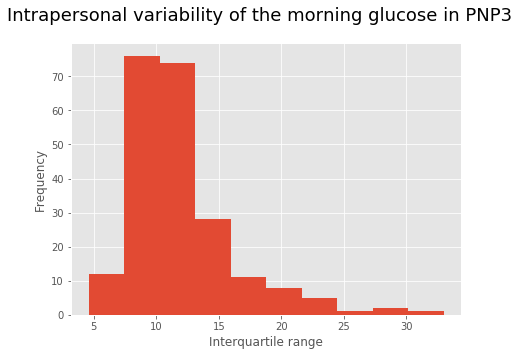

In [122]:
fig = plt.figure(figsize=(7,5))
fig.suptitle('Intrapersonal variability of the morning glucose in PNP3', fontsize=18)
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Interquartile range')
morn_gluc_distr['interquartile_range'].plot.hist()

In [123]:
morn_gluc_distr['interquartile_range'].mean()

11.936180075658099

### Todo: I should look at this values before and after the intervention and compare changes for the two diets. 

In [152]:
wakeup_glucose.shape

(25799, 4)

For how many days did people wear CGM sensor?

In [143]:
count = wakeup_glucose.groupby('RegistrationCode')['Day'].count()

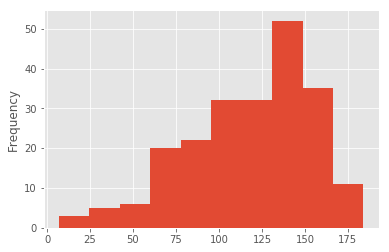

In [144]:
count.plot.hist()

Let's take all people with at least 50 days of  connections.

In [149]:
rc_to_keep = count[count >= 50].index

In [536]:
len(rc_to_keep)

207

We have 207 people in total.

## Leave only those people with more than 50 days of connections

In [638]:
def more_than_x_connection_days(wakeup_glucose_df, x=50):
    wakeup_glucose_df = wakeup_glucose_df.reset_index()
    count = wakeup_glucose_df.groupby('RegistrationCode')['Day'].count()
    rc_to_keep = count[count >= 50].index
    # wakeup_glucose = wakeup_glucose.set_index('RegistrationCode').loc[rc_to_keep]
    wakeup_glucose_df = wakeup_glucose_df[wakeup_glucose_df['RegistrationCode'].isin(rc_to_keep)].drop(columns='hour')
    return wakeup_glucose_df

In [639]:
wakeup_glucose_test = more_than_x_connection_days(wakeup_glucose_test)

In [643]:
wakeup_glucose_test = wakeup_glucose_test.drop(columns='index')

## Dietary features from the day before

In [647]:
def prepare_data_for_corr(wg_df, nutrient_list, study_ids=[3,49], min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18]):
    
    """Prepare joint df with wg and dietary features from the day before.
    One can choose to correlate with total diet from the perevious day or with diet split into breakfast, lunch and dinner.
    :param wg_df : wakeup_glucose DataFrame
    :param nutrient_list: list of nutrients to select (for the full list see LabData/DataLoaders/Lists/meal_features.txt)
                                e.g. ['energy_kcal', 'carbohydrate_g', 'protein_g', 'totallipid_g']
                                if None, all nutrients are selected
    :param min_cal_per_day:
    :param how: string, can be 'total_diet' or 'split_diet'. If split_diet is passed, then the day will be split into breakfast,
                        lunch and dinner and the nutrients will be calculated accordingly.
    :param daysplithours: list telling how to split the day 
        
    :return data_df with wg and dietary features to perform the correlations with
    """ 
    carbs_cal_per_gram = 4
    fat_cal_per_gram = 9
    prot_cal_per_gram = 4
    
    log = dll.get_data(study_ids=study_ids).df
    logdf = dll.add_nutrients(log, nutrient_list)
    logdf = dll.squeeze_log(logdf)
    logdf = logdf.reset_index()
    logdf['Day'] = logdf['Date'].dt.date
    #Identify days with good log more than min_cal_per_day
    totaldaylog = logdf.drop(columns=['meal_type']).groupby(['RegistrationCode', 'Day']).sum()
    totaldaylog = totaldaylog[totaldaylog['energy_kcal'] >= min_cal_per_day]
    days_to_keep = totaldaylog.index
    logdf = logdf.set_index(['RegistrationCode', 'Day'])
    logdf = logdf.loc[days_to_keep]
    
    if how == 'total_diet':
        # Add derived  features
        totaldaylog['carbs/lipids'] = totaldaylog['carbohydrate_g'] / totaldaylog['totallipid_g']
        totaldaylog['caloric%carbs'] = totaldaylog['carbohydrate_g'] * carbs_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%protein'] = totaldaylog['protein_g'] * prot_cal_per_gram / totaldaylog['energy_kcal']
        totaldaylog['caloric%fat'] = totaldaylog['totallipid_g'] * fat_cal_per_gram / totaldaylog['energy_kcal']
        # Change dtype to datetime for merge with wg_df
        totaldaylog = totaldaylog.reset_index('Day')
        totaldaylog['Day'] = pd.to_datetime(totaldaylog['Day'])
        # Add day to the current day for merge with correct wg
        totaldaylog['Day'] = totaldaylog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, totaldaylog, on=['RegistrationCode', 'Day'])
        
    elif how == 'split_diet':
        logdf['alloc'] = ''
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[0], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[1], 0, 0)),'alloc'] = 'b'
        logdf.loc[(logdf['Date'].dt.time >= datetime.time(daysplithours[1], 0, 0)) & 
              (logdf['Date'].dt.time < datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'l'
        logdf.loc[(logdf['Date'].dt.time > datetime.time(daysplithours[2], 0, 0)),'alloc'] = 'd' 
        # We are only interested in  food between 6 and 24. Days where people logged food during the night will be out after merge with wg_df
        logdf = logdf[logdf['alloc'] != '']
        splitlog = logdf.reset_index().groupby(['RegistrationCode', 'Day', 'alloc']).sum()
        splitlog = splitlog.unstack(level=-1)
        splitlog.columns = ['_'.join(splitlog.columns[i]) for i in range(len(splitlog.columns))]
        # Add carbs/lipids ration
        splitlog['carbs/lipids_b'] = splitlog['carbohydrate_g_b'] / splitlog['totallipid_g_b']
        splitlog['carbs/lipids_d'] = splitlog['carbohydrate_g_d'] / splitlog['totallipid_g_d']
        splitlog['carbs/lipids_l'] = splitlog['carbohydrate_g_l'] / splitlog['totallipid_g_l']
        # Change dtype to datetime for merge with wg_df        
        splitlog = splitlog.reset_index('Day')
        splitlog['Day'] = pd.to_datetime(splitlog['Day'])
        # Add day to the current day for merge with correct wg
        splitlog['Day'] = splitlog['Day'] + datetime.timedelta(days=1)
        data_for_corr = pd.merge(wg_df, splitlog, on=['RegistrationCode', 'Day'])

    return data_for_corr

Dietary features to test the correlations on:
'alcohol_g', 'caffeine_mg', 'carbohydrate_g', 'carbs/fat', 'energy_kcal', 'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g'

In [644]:
nutrient_list = ['caffeine_mg', 'carbohydrate_g', 'energy_kcal', 
                       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g', 'totallipid_g']

In [654]:
data_corr_total = prepare_data_for_corr(wakeup_glucose_test, nutrient_list, study_ids=[3,49], 
                                        min_cal_per_day=1000, how='total_diet', daysplithours=[6,12,18])
data_corr_split = prepare_data_for_corr(wakeup_glucose_test, nutrient_list, study_ids=[3,49], 
                                        min_cal_per_day=1000, how='split_diet', daysplithours=[6,12,18])

In [655]:
data_corr_total.shape

(22699, 16)

In [659]:
data_corr_split.isnull().sum()

RegistrationCode            0
Day                         0
wakeup_glucose              0
sodium_mg_b               820
sodium_mg_d              1117
sodium_mg_l               492
sugarstotal_g_b           820
sugarstotal_g_d          1117
sugarstotal_g_l           492
totallipid_g_b            820
totallipid_g_d           1117
totallipid_g_l            492
protein_g_b               820
protein_g_d              1117
protein_g_l               492
carbohydrate_g_b          820
carbohydrate_g_d         1117
carbohydrate_g_l          492
totaldietaryfiber_g_b     820
totaldietaryfiber_g_d    1117
totaldietaryfiber_g_l     492
energy_kcal_b             820
energy_kcal_d            1117
energy_kcal_l             492
weight_b                  820
weight_d                 1117
weight_l                  492
caffeine_mg_b             820
caffeine_mg_d            1117
caffeine_mg_l             492
carbs/lipids_b            830
carbs/lipids_d           1122
carbs/lipids_l            496
dtype: int

In [ ]:
def corr_wg_dietdaybefore(wg_df, method='Spearman'):
    """Calculate correlations between the wakeup glucose (WG) and the diet the day before"""
    

Normality testing method

In [471]:
# from numpy.random import seed
# from numpy.random import randn
# from scipy.stats import shapiro
# # seed the random number generator
# seed(1)
# # normality test
# for column in data.columns:
#     stat, p = shapiro(data.loc['300747'][column])
#     print('Statistics=%.3f, p=%.3f' % (stat, p))
#     # interpret
#     alpha = 0.05
#     if p > alpha:
#         print(column, ': Sample looks Gaussian (fail to reject H0)')
#     else:
#         print(column, ': Sample does not look Gaussian (reject H0)')

In [663]:
data_corr_total = data_corr_total.drop(columns='Day')

KeyError: "['Day'] not found in axis"

In [671]:
data_corr_total.head()

,wakeup_glucose,sodium_mg,sugarstotal_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,weight,caffeine_mg,carbs/lipids,caloric%carbs,caloric%protein,caloric%fat
RegistrationCode,,,,,,,,,,,,,,
111527,103.071429,2000.838539,6.538000,79.052895,73.624292,231.320475,12.664168,1919.71453,2350.14,558.00,2.926148,0.481989,0.153407,0.370616
111527,98.071429,1691.501330,6.313964,58.201139,50.789459,194.751503,11.263018,1517.15022,2135.04,562.50,3.346180,0.513467,0.133908,0.345259
111527,101.321429,2289.811585,5.414400,73.305995,79.098687,265.900131,13.546815,2087.21548,2037.62,328.50,3.627263,0.509579,0.151587,0.316093
111527,107.071429,1862.517280,25.698000,44.786748,48.809778,160.317880,16.807222,1317.76292,1488.03,328.50,3.579583,0.486636,0.148160,0.305883
111527,106.071429,3063.713740,83.697100,70.233976,78.098902,231.655018,12.343034,1871.10702,1950.01,305.22,3.298333,0.495226,0.166958,0.337824


In [667]:
means = data_corr_total.groupby('RegistrationCode').mean()

In [668]:
std = data_corr_total.groupby('RegistrationCode').std()

In [670]:
data_corr_total = data_corr_total.set_index('RegistrationCode')

In [672]:
# standartization of the values into z scores
for rc in data_corr_total.index.unique():
    data_corr_total.loc[rc] = (data_corr_total.loc[rc] - means.loc[rc])/std.loc[rc]

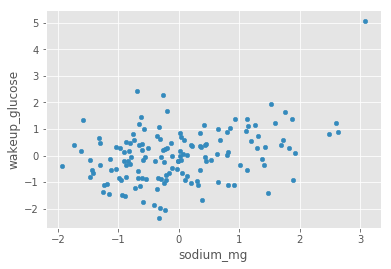

In [673]:
data_corr_total.loc['132178'].plot.scatter(x='sodium_mg', y='wakeup_glucose')

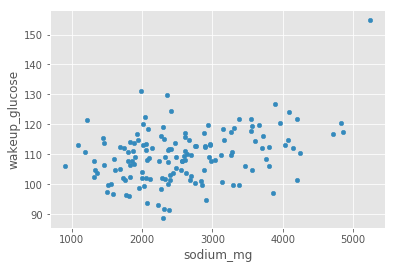

In [318]:
data.loc['132178'].plot.scatter(x='sodium_mg', y='wakeup_glucose')

In PNP3 patients probably avoided alcohol due to the diet. I should exclude this feature from the correlation analysis.

In [674]:
spearmancorr = data_corr_total.corr(method='spearman')
spearmancorr

,wakeup_glucose,sodium_mg,sugarstotal_g,totallipid_g,protein_g,carbohydrate_g,totaldietaryfiber_g,energy_kcal,weight,caffeine_mg,carbs/lipids,caloric%carbs,caloric%protein,caloric%fat
wakeup_glucose,1.000000,0.023837,0.021271,0.029580,0.041650,0.053649,0.025154,0.050646,0.067389,0.022523,0.015132,0.019710,0.004108,-0.011349
sodium_mg,0.023837,1.000000,-0.005716,0.226733,0.393104,0.265782,0.228632,0.414722,0.434672,0.057449,0.034099,-0.006534,0.129134,-0.098929
sugarstotal_g,0.021271,-0.005716,1.000000,0.034631,0.063299,0.309526,0.326756,0.190437,0.298332,0.078665,0.217930,0.234729,-0.087155,-0.153522
totallipid_g,0.029580,0.226733,0.034631,1.000000,0.289128,0.102696,0.098986,0.744719,0.198455,0.046391,-0.582818,-0.447509,-0.243607,0.687021
protein_g,0.041650,0.393104,0.063299,0.289128,1.000000,0.102821,0.137309,0.546755,0.367305,0.065468,-0.121827,-0.306339,0.714052,-0.162568
carbohydrate_g,0.053649,0.265782,0.309526,0.102696,0.102821,1.000000,0.411024,0.566688,0.398031,0.080195,0.635496,0.723004,-0.342990,-0.435956
totaldietaryfiber_g,0.025154,0.228632,0.326756,0.098986,0.137309,0.411024,1.000000,0.319926,0.352942,0.053241,0.250905,0.252591,-0.106411,-0.181321
energy_kcal,0.050646,0.414722,0.190437,0.744719,0.546755,0.566688,0.319926,1.000000,0.464660,0.083739,-0.080735,-0.044834,-0.118548,0.112967
weight,0.067389,0.434672,0.298332,0.198455,0.367305,0.398031,0.352942,0.464660,1.000000,0.457592,0.148331,0.116634,0.056495,-0.190802
caffeine_mg,0.022523,0.057449,0.078665,0.046391,0.065468,0.080195,0.053241,0.083739,0.457592,1.000000,0.022018,0.027407,0.005577,-0.020028


In [469]:
# sb.heatmap(pearsoncorr, 
#             xticklabels=pearsoncorr.columns,
#             yticklabels=pearsoncorr.columns,
#             cmap='RdBu_r',
#             annot=True,
#             linewidth=0.5)

In [362]:
# def calculate_pvalues(df):
#     df = df.dropna()._get_numeric_data()
#     dfcols = pd.DataFrame(columns=df.columns)
#     pvalues = dfcols.transpose().join(dfcols, how='outer')
#     for r in df.columns:
#         for c in df.columns:
#             pvalues[r][c] = round(spearmanr(df[r], df[c])[1], 4)
#     return pvalues

# calculate_pvalues(data.loc['111527']) 

In [675]:
data_corr_total = round(data_corr_total, 4)

In [677]:
statistics_df = pd.DataFrame(means.stack(level=-1))

In [680]:
statistics_df['rho'] = 0
statistics_df['pvalue'] = 0
statistics_df = statistics_df.drop(columns=0)

In [683]:
statistics_df.head()

rho    pvalue
RegistrationCode                                   
111527           wakeup_glucose  1.000000  0.000000
                 sodium_mg       0.008531  0.922064
                 sugarstotal_g   0.116687  0.179374
                 totallipid_g   -0.190140  0.027770
                 protein_g       0.005120  0.953182

In [682]:
for rc in data_corr_total.index.unique():
    for column in data_corr_total.columns:
        spearman = spearmanr(data_corr_total.loc[rc]['wakeup_glucose'], data_corr_total.loc[rc][column])
        statistics_df.loc[(rc, column), 'rho'] = spearman[0]
        statistics_df.loc[(rc, column), 'pvalue'] = spearman[1]

In [685]:
pvalues = statistics_df['pvalue']

In [458]:
# from statsmodels.stats.multitest import multipletests
# multipletests(pvalues, alpha=0.05, method='fdr_by', is_sorted=False, returnsorted=False)

(array([ True, False, False, ...,  True, False, False]),
 array([0.        , 1.        , 1.        , ..., 0.00164012, 0.87594188,
        1.        ]),
 1.9607336209315207e-05,
 1.9113149847094803e-05)

In [687]:
pvalues_corrected = pd.Series(fdrcorrection(pvalues[1]))

In [688]:
pvalues_corrected.index = statistics_df.index

ValueError: Length mismatch: Expected axis has 2 elements, new values have 2898 elements

In [463]:
statistics_df['pvalues_corrected'] = pvalues_corrected
statistics_df.head()

rho    pvalue  pvalues_corrected
RegistrationCode                                                      
111527           wakeup_glucose  1.000000  0.000000           0.000000
                 sodium_mg       0.008531  0.922064           0.975776
                 sugarstotal_g   0.116687  0.179374           0.407329
                 alcohol_g       0.000000  0.000000           0.000000
                 totallipid_g   -0.190140  0.027770           0.105132

In [465]:
statistics_df[(statistics_df['rho'] > 0.3) & (statistics_df['pvalues_corrected'] < 0.05) & 
              (statistics_df.index.get_level_values(-1) != 'wakeup_glucose')]

rho        pvalue  pvalues_corrected
RegistrationCode                                                          
126092           weight          0.316931  1.906980e-04       1.065953e-03
12752            caffeine_mg     0.436133  7.342705e-05       4.203176e-04
136529           energy_kcal     0.372959  3.191714e-05       1.847240e-04
158748           carbohydrate_g  0.318045  8.427241e-04       4.508315e-03
                 caffeine_mg     0.325417  6.257751e-04       3.382288e-03
...                                   ...           ...                ...
933765           carbohydrate_g  0.435482  1.074835e-08       6.434253e-08
                 energy_kcal     0.368453  1.904740e-06       1.122252e-05
                 carbs/lipids    0.355952  4.433299e-06       2.600339e-05
997735           energy_kcal     0.316560  3.046739e-04       1.685046e-03
                 weight          0.360568  3.362357e-05       1.941706e-04

[62 rows x 3 columns]

In [472]:
statistics_df['significant'] = 0

In [476]:

statistics_df.loc[(statistics_df['pvalues_corrected'] < 0.05),'significant'] = 1

In [477]:
statistics_df.head()

rho  ...  significant
RegistrationCode                           ...             
111527           wakeup_glucose  1.000000  ...            1
                 sodium_mg       0.008531  ...            0
                 sugarstotal_g   0.116687  ...            0
                 alcohol_g       0.000000  ...            1
                 totallipid_g   -0.190140  ...            0

[5 rows x 4 columns]

In [468]:
# for rc in data.index.unique():
#     for column in data.columns:
#         pearson = pearsonr(data.loc[rc]['wakeup_glucose'], data.loc[rc][column])
#         if abs(pearson[0]) > 0.3 and pearson[1] < 0.05 and column != 'wakeup_glucose':
#             print(rc, column, pearson)

In [494]:
statistics_df = statistics_df.fillna(0)

In [498]:
statistics_df.dtypes

RegistrationCode      object
level_1               object
rho                  float64
pvalue               float64
pvalues_corrected    float64
significant            int64
dtype: object

In [503]:
statistics_df = statistics_df.reset_index('RegistrationCode')

In [499]:
print(statistics_df['level_1'], statistics_df['rho'])

0            wakeup_glucose
1                 sodium_mg
2             sugarstotal_g
3                 alcohol_g
4              totallipid_g
               ...         
2611    totaldietaryfiber_g
2612            energy_kcal
2613                 weight
2614            caffeine_mg
2615           carbs/lipids
Name: level_1, Length: 2616, dtype: object 0       1.000000
1       0.008531
2       0.116687
3       0.000000
4      -0.190140
          ...   
2611    0.292845
2612    0.316560
2613    0.360568
2614    0.196802
2615    0.137503
Name: rho, Length: 2616, dtype: float64


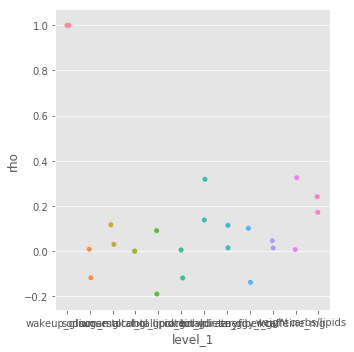

In [506]:
sns.catplot(x='level_1', y='rho', data=statistics_df[(statistics_df['RegistrationCode'] =='158748') | (statistics_df['RegistrationCode'] =='111527')]);

In [510]:
statistics_df.loc[(statistics_df['significant'] == 0), 'rho'] = None

In [515]:
statistics_df = statistics_df[(statistics_df['level_1'] != 'wakeup_glucose') & (statistics_df['level_1'] != 'alcohol_g')]

In [512]:
statistics_df.head()

,RegistrationCode,level_1,rho,pvalue,pvalues_corrected,significant
1,111527,sodium_mg,NaN,0.922064,0.975776,0
2,111527,sugarstotal_g,NaN,0.179374,0.407329,0
3,111527,alcohol_g,0.0,0.000000,0.000000,1
4,111527,totallipid_g,NaN,0.027770,0.105132,0
5,111527,protein_g,NaN,0.953182,0.983639,0


In [517]:
signif_corr = statistics_df.set_index(['RegistrationCode', 'level_1']).unstack(level=-1)['rho']

In [518]:
signif_corr.columns.name = None

In [521]:
signif_corr.columns

Index(['caffeine_mg', 'carbohydrate_g', 'carbs/lipids', 'energy_kcal',
       'protein_g', 'sodium_mg', 'sugarstotal_g', 'totaldietaryfiber_g',
       'totallipid_g', 'weight'],
      dtype='object')

In [522]:
rc_list = signif_corr.index
rc_list = ['rc' + item for item in rc_list]
diet_feat_list = signif_corr.columns

In [523]:
sign_corr_list = signif_corr.values.tolist()

In [526]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=sign_corr_list,
                   x=diet_feat_list,
                   y=rc_list,
                   hoverongaps = False))
fig.update_layout(
    title={
        'text': "Personalized correlations between the wakeup glucose and dietary features from the day before",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Dietary features",
    yaxis_title="RegistrationCode"
    )
#fig.write_html("/home/elming/Cache/plotly_figures/personalized_corr_pnp3.html")
fig.show()